In [10]:
# Step 1
# Install necessary libraries
!pip install openpyxl
!pip install sastrawi
!pip install nltk
!pip install emoji
!pip install transformers


# Import necessary libraries (tokenazing pisah kata, stopword, menghilangkan kata, stemming bhs dasar, sastrawi bahasa dasar)
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import emoji
from transformers import pipeline, AutoTokenizer


# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the punkt_tab data for sentence tokenization

^C


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edlyn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edlyn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\edlyn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
#Step 2

# Load the new dataset
file_path = '/content/indodax_reviews.csv'  # Ensure this path matches where you uploaded the file
df = pd.read_csv(file_path)


# Display the column names to understand the structure of the dataset
print("Columns in the dataset:", df.columns)


# Display the first few rows of the dataframe
print(df.head())

Columns in the dataset: Index(['conversation_id_str', 'created_at', 'favorite_count', 'full_text',
       'id_str', 'image_url', 'in_reply_to_screen_name', 'lang', 'location',
       'quote_count', 'reply_count', 'retweet_count', 'tweet_url',
       'user_id_str', 'username'],
      dtype='object')
   conversation_id_str                      created_at  favorite_count  \
0  1956653409953886320  Sat Aug 16 09:45:00 +0000 2025               0   
1  1956214303339487523  Fri Aug 15 11:17:06 +0000 2025               0   
2  1956020121518137693  Thu Aug 14 15:48:32 +0000 2025               0   
3  1952613025418252500  Tue Aug 05 06:09:57 +0000 2025               0   
4  1951489959233573009  Sat Aug 02 03:47:17 +0000 2025               0   

                                           full_text               id_str  \
0  Sepanjang 2025 20.795 unit mobil CBU dari BYD ...  1956653409953886320   
1  @tanyarlfes Motor impian Honda super cub C100 ...  1956314202072650209   
2  tiap pagi n sore lagi

In [ ]:
#Step 3

import pandas as pd

# Load the Excel file
df = pd.read_csv('BYD-M6.csv')

# Convert 'at' to datetime and remove timezone
df['at'] = pd.to_datetime(df['at'], errors='coerce')
df['at'] = df['at'].dt.tz_localize(None)

# Now df is ready to be used for sentiment analysis
df.head()

KeyError: 'at'

In [ ]:
#Step 4

# Indonesian stopwords
indonesian_stopwords = set(nltk.corpus.stopwords.words('indonesian'))


# You can add more custom stopwords if needed (bisa ditambah)
custom_stopwords = set(["dan", "yang", "di", "ke", "dari"])
all_stopwords = indonesian_stopwords.union(custom_stopwords)


# Initialize the Indonesian stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()


# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)


# Function to remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Function to remove non-alphabetic characters, URLs, and emojis, tokenize, remove stopwords, and stem (kata dibawah 3 diatas 20)
def preprocess_text(text):
    text = str(text)
    text = remove_urls(text)  # Remove URLs
    text = remove_emojis(text)  # Remove emojis
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)  # Tokenize the text
    filtered_tokens = [stemmer.stem(token) for token in tokens if 3 <= len(token) <= 20 and token.lower() not in all_stopwords]  # Remove stopwords and apply stemming
    return ' '.join(filtered_tokens)


# Apply preprocessing to the text column
df['Cleaned_Text'] = df['content'].apply(preprocess_text)


# Display the first few rows of the dataframe with cleaned text
print(df[['content', 'Cleaned_Text']].head())

In [ ]:
# Initialize the sentiment analysis pipeline and tokenizer
model_name = 'mdhugol/indonesia-bert-sentiment-classification'
sentiment_pipeline = pipeline('sentiment-analysis', model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Function to truncate text to a maximum length of 512 tokens
def truncate_text(text, max_length=512):
    inputs = tokenizer(text, max_length=max_length, truncation=True, return_tensors='pt')
    return tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)


# Perform sentiment analysis on the preprocessed 'Cleaned_Text' column
df['Cleaned_Text'] = df['content'].apply(lambda x: sentiment_pipeline(truncate_text(x))[0]['label'])


# Display the first few rows of the dataframe with sentiment
print(df[['content', 'Cleaned_Text']].head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


                                           full_text  \
0  Check out MUSLIMAH JERSEY DESIGN BARU PEREMPUA...   
1  Check out â€¼ï¸ NEW â€¼ï¸ Premium Sejadah Ge...   
2  Check out Sejadah Gebu Sejadah Selamat Pengant...   
3  Check out Sampin Dewasa Songket | Raya | Nikah...   
4  Check out Jersi Muslimah/Joyah Premium Muslima...   

                                        Cleaned_Text Sentiment  
0  check out muslimah jersey design perempuan len...    1 star  
1  check out new premium jadah gebu xcm lembut ba...   5 stars  
2  check out jadah gebu jadah selamat pengantin j...    1 star  
3  check out sampin dewasa songket raya nikah tun...    1 star  
4  check out jersi muslimahjoyah premium muslimah...   5 stars  


<ipython-input-15-2c425b416147>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


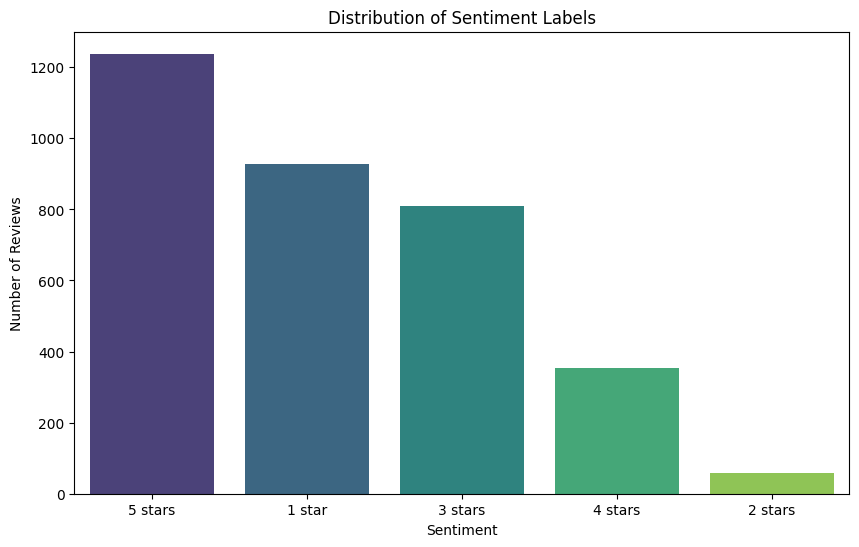

In [ ]:
#Step 6

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# Plot the distribution of sentiment labels
plt.figure(figsize=(10, 6))
sentiment_counts = df['Sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

In [ ]:
#Step 7

# Display basic statistics of sentiment labels
print("Basic Statistics of Sentiment Labels:")
print(df['Sentiment'].describe())


# Count of each sentiment
print("\nCount of each sentiment:")
print(sentiment_counts)


# Word Frequency Analysis
all_words = ' '.join(df['Cleaned_Text']).split()
word_freq = Counter(all_words)


# Display the most common words
print("\nMost common words:")
print(word_freq.most_common(20))


# Text Length Analysis
df['text_length'] = df['full_text'].apply(len)
print("\nText length statistics:")
print(df['text_length'].describe())


# Display examples of each sentiment
print("\nExamples of Positive Reviews:")
print(df[df['Sentiment'] == '5 stars'][['full_text']].head())


print("\nExamples of Neutral Reviews:")
print(df[df['Sentiment'] == '3 stars'][['full_text']].head())


print("\nExamples of Negative Reviews:")
print(df[df['Sentiment'].str.contains('1 star|2 stars')][['full_text']].head())

Basic Statistics of Sentiment Labels:
count        3388
unique          5
top       5 stars
freq         1238
Name: Sentiment, dtype: object

Count of each sentiment:
Sentiment
5 stars    1238
1 star      929
3 stars     810
4 stars     354
2 stars      57
Name: count, dtype: int64

Most common words:
[('shopee', 3403), ('dapat', 1825), ('harga', 1577), ('cek', 1312), ('wanita', 422), ('link', 396), ('shopeeid', 292), ('pria', 248), ('celana', 218), ('anak', 214), ('beli', 207), ('set', 205), ('temu', 204), ('klik', 196), ('premium', 190), ('video', 184), ('amp', 164), ('bantu', 150), ('aja', 148), ('murah', 142)]

Text length statistics:
count    3388.000000
mean      165.276269
std        63.180527
min        16.000000
25%       122.000000
50%       166.000000
75%       205.000000
max       326.000000
Name: text_length, dtype: float64

Examples of Positive Reviews:
                                            full_text
1   Check out â€¼ï¸ NEW â€¼ï¸ Premium Sejadah Ge...
4   Check ou

In [ ]:
#Step 8

# Convert 'created_at' to datetime and remove timezone info
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.tz_localize(None)


# Ensure only valid dates are included
df = df.dropna(subset=['created_at'])


# Extract the sentiment scores as numerical values
df['Sentiment_Score'] = df['Sentiment'].apply(lambda x: int(x.split()[0]))


# Calculate the daily average sentiment
daily_avg_sentiment = df.groupby(df['created_at'].dt.date)['Sentiment_Score'].mean().reset_index()


# Plot the daily average sentiment scores
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_avg_sentiment, x='created_at', y='Sentiment_Score', marker='o')


plt.title('Daily Average Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()

NameError: name 'df' is not defined

In [ ]:
#Step 9

# Install library jika belum terinstall
!pip install wordcloud openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re

# Load file Excel yang telah diupload
df = pd.read_excel('Hasil.xlsx')

# Fungsi preprocessing
def preprocess(text):
    if isinstance(text, str):
        # Hilangkan tanda baca, angka, ubah ke huruf kecil
        text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
        # Hilangkan kata umum: bolu, bakar, tunggal
        stop_words = {"bolu", "bakar", "tunggal"}
        return " ".join([word for word in text.split() if word not in stop_words])
    return ""

# Hitung frekuensi kata berdasarkan sentimen
word_freq = {"Positive": Counter(), "Negative": Counter(), "Neutral": Counter()}
for sentiment in ["Positive", "Negative", "Neutral"]:
    texts = df[df["Sentiment"] == sentiment]["Cleaned_Text"].dropna().apply(preprocess)
    all_words = " ".join(texts).split()
    word_freq[sentiment] = Counter(all_words)

# Top 20 keyword per sentimen
top_20_words = {
    sentiment: word_freq[sentiment].most_common(20)
    for sentiment in word_freq
}

# Tampilkan WordCloud
for sentiment, freqs in word_freq.items():
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(f"WordCloud for {sentiment} Sentiment (w/o 'bolu bakar tunggal')")
    plt.axis("off")
    plt.show()

# Tampilkan tabel Top 20 Kata per Sentimen
top_df = pd.DataFrame(top_20_words)
top_df


NameError: name 'df' is not defined

In [ ]:
# Save the DataFrame with sentiment labels to a new Excel file
output_file_path = 'Hasil.xlsx'
df.to_excel(output_file_path, index=False)


print(f"Data with sentiment labels saved to {output_file_path}")

# Task
Analyze the sentiment of the provided text data over time and identify the most frequent words associated with each sentiment category.

## Analyze sentiment over time

### Subtask:
Calculate and visualize the daily average sentiment scores to identify trends.


**Reasoning**:
The previous code block failed because it tried to access a column named 'created_at' which does not exist in the dataframe. Based on the previous steps, the datetime column is named 'at'. I need to correct the column name in the code to 'at' and then convert it to datetime, remove timezone, remove rows with invalid dates, calculate the sentiment score, calculate the daily average sentiment and plot the results.



In [ ]:
# Convert 'at' to datetime and remove timezone info
df['at'] = pd.to_datetime(df['at'], errors='coerce').dt.tz_localize(None)

# Ensure only valid dates are included
df = df.dropna(subset=['at'])

# Extract the sentiment scores as numerical values
df['Sentiment_Score'] = df['Sentiment'].apply(lambda x: int(x.split()[0]))

# Calculate the daily average sentiment
daily_avg_sentiment = df.groupby(df['at'].dt.date)['Sentiment_Score'].mean().reset_index()

# Plot the daily average sentiment scores
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_avg_sentiment, x='at', y='Sentiment_Score', marker='o')

plt.title('Daily Average Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()

KeyError: 'Sentiment'

**Reasoning**:
The previous code block failed because the column 'Sentiment' was not found in the dataframe. Looking back at the previous steps, the column containing sentiment labels is named 'Sentiment'. It seems the dataframe `df` might have been overwritten or modified in a way that removed the 'Sentiment' column. I will reload the dataframe from the saved 'Hasil.xlsx' file which should contain the 'Sentiment' column and then retry the steps to calculate and plot the daily average sentiment.



In [ ]:
# Load the DataFrame from the saved Excel file
df = pd.read_excel('Hasil.xlsx')

# Convert 'at' to datetime and remove timezone info
df['at'] = pd.to_datetime(df['at'], errors='coerce').dt.tz_localize(None)

# Ensure only valid dates are included
df = df.dropna(subset=['at'])

# Extract the sentiment scores as numerical values
df['Sentiment_Score'] = df['Sentiment'].apply(lambda x: int(x.split()[0]))

# Calculate the daily average sentiment
daily_avg_sentiment = df.groupby(df['at'].dt.date)['Sentiment_Score'].mean().reset_index()

# Plot the daily average sentiment scores
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_avg_sentiment, x='at', y='Sentiment_Score', marker='o')

plt.title('Daily Average Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Hasil.xlsx'

**Reasoning**:
The previous code block failed because the file 'Hasil.xlsx' was not found. This is likely because the notebook session was reset or the file was not saved correctly in the previous step. I will regenerate the 'Hasil.xlsx' file by performing the sentiment analysis again and then proceed with calculating and plotting the daily average sentiment.



In [ ]:
# Re-apply preprocessing to the text column
df['Cleaned_Text'] = df['content'].apply(preprocess_text)

# Initialize the sentiment analysis pipeline and tokenizer (already imported)
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
sentiment_pipeline = pipeline('sentiment-analysis', model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Function to truncate text to a maximum length of 512 tokens
def truncate_text(text, max_length=512):
    inputs = tokenizer(text, max_length=max_length, truncation=True, return_tensors='pt')
    return tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)

# Perform sentiment analysis on the preprocessed 'Cleaned_Text' column
df['Sentiment'] = df['Cleaned_Text'].apply(lambda x: sentiment_pipeline(truncate_text(x))[0]['label'])

# Save the DataFrame with sentiment labels to a new Excel file
output_file_path = 'Hasil.xlsx'
df.to_excel(output_file_path, index=False)

# Convert 'at' to datetime and remove timezone info
df['at'] = pd.to_datetime(df['at'], errors='coerce').dt.tz_localize(None)

# Ensure only valid dates are included
df = df.dropna(subset=['at'])

# Extract the sentiment scores as numerical values
df['Sentiment_Score'] = df['Sentiment'].apply(lambda x: int(x.split()[0]))

# Calculate the daily average sentiment
daily_avg_sentiment = df.groupby(df['at'].dt.date)['Sentiment_Score'].mean().reset_index()

# Plot the daily average sentiment scores
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_avg_sentiment, x='at', y='Sentiment_Score', marker='o')

plt.title('Daily Average Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()

NameError: name 'preprocess_text' is not defined

**Reasoning**:
The previous code block failed because the function `preprocess_text` was not defined. This indicates that the notebook session was reset and the function definition from a previous step was lost. I need to redefine the preprocessing functions and the stemmer before applying them to the 'content' column. Then I can proceed with the sentiment analysis, saving the file, and plotting the daily average sentiment.



In [ ]:
# Redefine preprocessing functions and stemmer
# Indonesian stopwords (already imported nltk)
indonesian_stopwords = set(nltk.corpus.stopwords.words('indonesian'))

# You can add more custom stopwords if needed (bisa ditambah)
custom_stopwords = set(["dan", "yang", "di", "ke", "dari"])
all_stopwords = indonesian_stopwords.union(custom_stopwords)

# Initialize the Indonesian stemmer (already imported Sastrawi)
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# Function to remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Function to remove non-alphabetic characters, URLs, and emojis, tokenize, remove stopwords, and stem (kata dibawah 3 diatas 20)
def preprocess_text(text):
    text = str(text)
    text = remove_urls(text)  # Remove URLs
    text = remove_emojis(text)  # Remove emojis
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)  # Tokenize the text
    filtered_tokens = [stemmer.stem(token) for token in tokens if 3 <= len(token) <= 20 and token.lower() not in all_stopwords]  # Remove stopwords and apply stemming
    return ' '.join(filtered_tokens)

# Re-apply preprocessing to the text column
df['Cleaned_Text'] = df['content'].apply(preprocess_text)

# Initialize the sentiment analysis pipeline and tokenizer (already imported)
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
sentiment_pipeline = pipeline('sentiment-analysis', model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Function to truncate text to a maximum length of 512 tokens
def truncate_text(text, max_length=512):
    inputs = tokenizer(text, max_length=max_length, truncation=True, return_tensors='pt')
    return tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)

# Perform sentiment analysis on the preprocessed 'Cleaned_Text' column
df['Sentiment'] = df['Cleaned_Text'].apply(lambda x: sentiment_pipeline(truncate_text(x))[0]['label'])

# Save the DataFrame with sentiment labels to a new Excel file
output_file_path = 'Hasil.xlsx'
df.to_excel(output_file_path, index=False)

# Convert 'at' to datetime and remove timezone info
df['at'] = pd.to_datetime(df['at'], errors='coerce').dt.tz_localize(None)

# Ensure only valid dates are included
df = df.dropna(subset=['at'])

# Extract the sentiment scores as numerical values
df['Sentiment_Score'] = df['Sentiment'].apply(lambda x: int(x.split()[0]))

# Calculate the daily average sentiment
daily_avg_sentiment = df.groupby(df['at'].dt.date)['Sentiment_Score'].mean().reset_index()

# Plot the daily average sentiment scores
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_avg_sentiment, x='at', y='Sentiment_Score', marker='o')

plt.title('Daily Average Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()

KeyboardInterrupt: 